In [1]:
###########
# こちらの記事を参考
# https://jundoll.hatenablog.com/entry/2014/11/16/151332
###########

## 平滑化用関数
MW <- function(dat, width, na.rm = TRUE) {
  N <- length(dat)
  x <- numeric(N)
  for(i in 1L:(width-1L)) {
    x[i] <- mean(dat[1L:i], na.rm = na.rm)
  }
  for(i in width:N) {
    x[i] <- mean(dat[(i-width+1L):i], na.rm = na.rm)
  }
  return(x)
}

## 擬似逆行列計算用関数（MASSパッケージより）
ginv <- function (X, tol = sqrt(.Machine$double.eps)) {
  if (length(dim(X)) > 2L || !(is.numeric(X) || is.complex(X))) 
    stop("'X' must be a numeric or complex matrix")
  if (!is.matrix(X)) 
    X <- as.matrix(X)
  Xsvd <- svd(X)
  if (is.complex(X)) 
    Xsvd$u <- Conj(Xsvd$u)
  Positive <- Xsvd$d > max(tol * Xsvd$d[1L], 0)
  if (all(Positive)) 
    Xsvd$v %*% (1/Xsvd$d * t(Xsvd$u))
  else if (!any(Positive)) 
    array(0, dim(X)[2L:1L])
  else Xsvd$v[, Positive, drop = FALSE] %*% ((1/Xsvd$d[Positive]) * t(Xsvd$u[, Positive, drop = FALSE]))
}

SDAR1 <- function(x, ar_order, forgetting, mu = 0, co = numeric(ar_order+1), w = numeric(ar_order), S = 0) {
  N <- length(x)
  score <- numeric(N)
  for(t in (ar_order+1L):N) {
    mu <- (1-forgetting)*mu + forgetting*x[t]
    co <- (1-forgetting)*co + forgetting*(x[t]-mu)*(x[t-(0:ar_order)]-mu)
    w <- c(ginv(matrix(co[abs(rep(1:ar_order, ar_order)-rep(1:ar_order, each=ar_order))+1], ar_order, ar_order)) %*% co[-1])
    x_hat <- c(w %*% (x[t-(1:ar_order)]-mu)) + mu
    S <- (1-forgetting)*S + forgetting*(x[t]-x_hat)^2
    score[t] <- (log(2*pi*S) + (x[t] - x_hat)^2 / S) / 2
  }
  list(Score = score, x = x)
}

CF <- function(x, ar_order, forgetting, width1, width2 = width1, na.rm = TRUE) {
  Step1 <- SDAR1(x, ar_order, forgetting)$Score
  Step2 <- MW(Step1, width1, na.rm)
  Step3 <- MW(SDAR1(Step2, ar_order, forgetting)$Score, width2, na.rm)
  return(Step3)
}


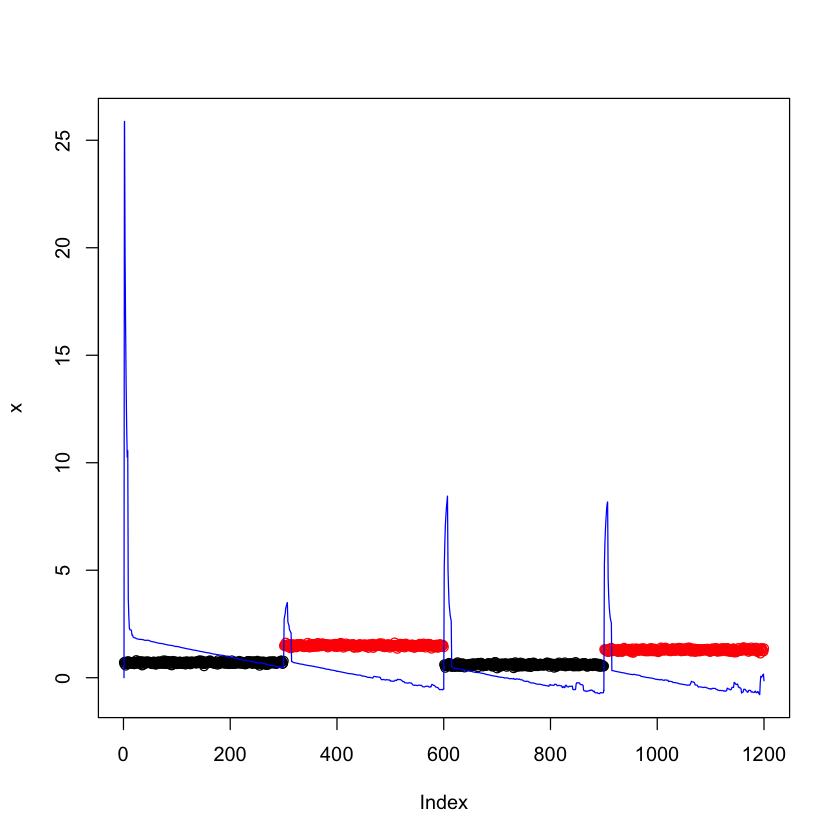

In [2]:
# test
x <- c(rnorm(300, 0.7, 0.05), 
       rnorm(300, 1.5, 0.05), 
       rnorm(300, 0.6, 0.05), 
       rnorm(300, 1.3, 0.05))
CF_test <- CF(x, 1, 0.01, 7, 7)
plot(x, col = rep(c(1:2, 1:2), each = 300), ylim = range(x, CF_test))
lines(CF_test, col = 4)

sensor: 999

length of packet_alert: 10

length of host_alert: 5

length of alert: 15



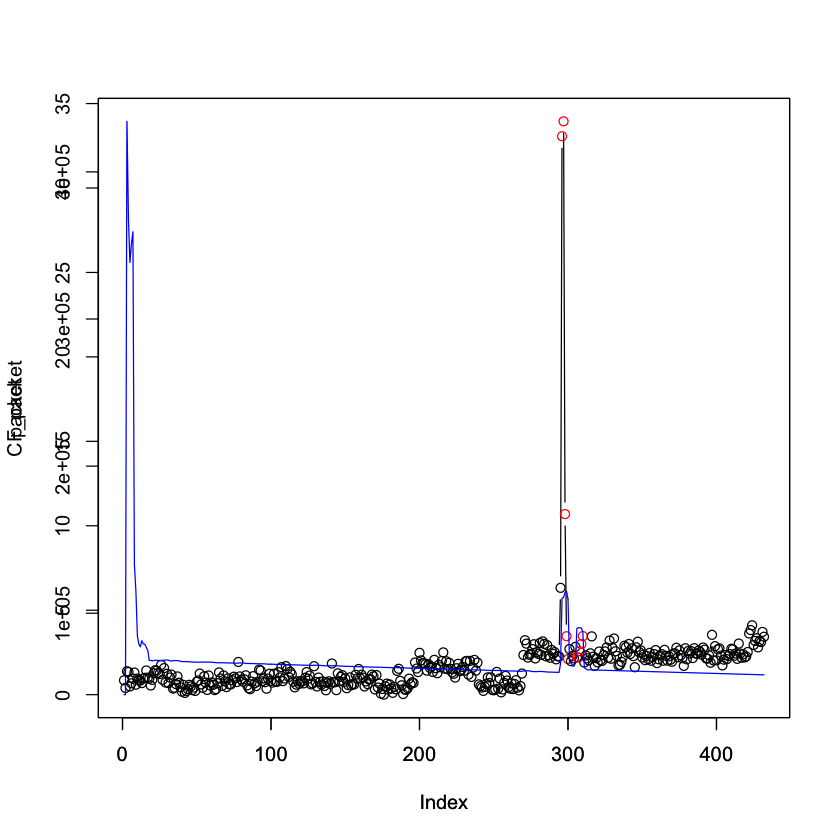

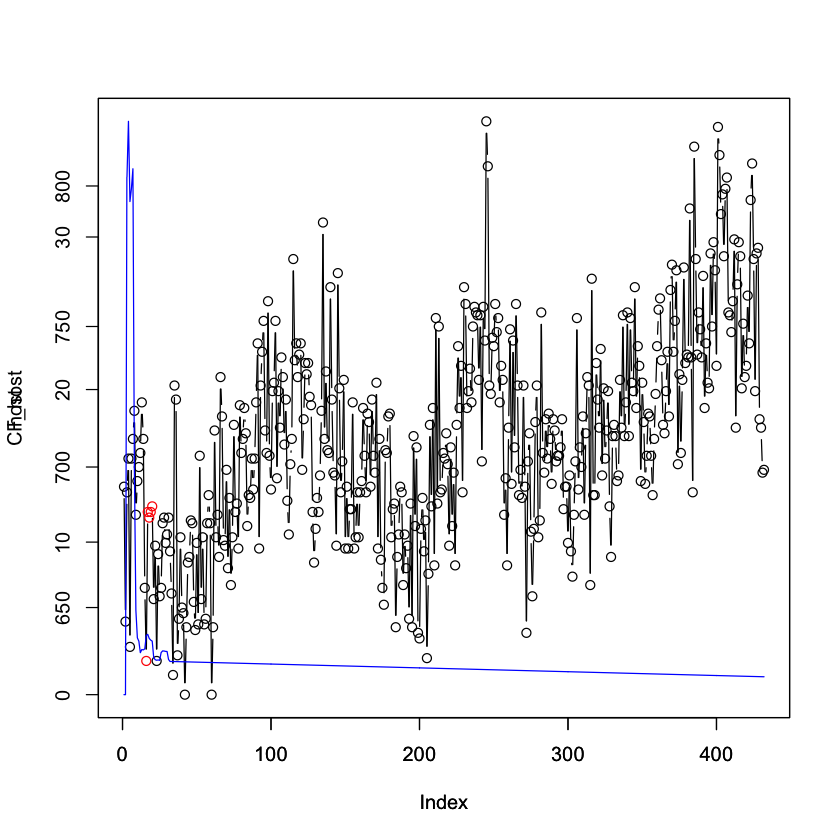

In [4]:
sensor_all<-c(999)
for(s in 1:length(sensor_all)){
    hoge <- read.csv(paste0("count_data/sensor",sensor_all[s],"_count.csv"), header=T)
    packet<- as.numeric(hoge$packetnum)
    host <- as.numeric(hoge$hostnum)

    ##########
    # Parameter 設定 (データによってパラメータの値を確認! 特にしきい値とエラーの値)
    # AR model の次数: 2
    # 忘却パラメータ: 0.005
    # 平滑化の範囲: 10, 5 (2段階)
    # しきい値: 3
    # エラー: 15
    ##########
    CF_packet <- CF(packet, 2, 0.005, 10, 5) 
    CF_host <- CF(host, 2, 0.005, 10, 5)
    thre<-3  # しきい値
    err<-15  # 15番目のデータまでは必ずアラートになってしまうので，エラーとして除外

    ##########
    # CF_packet
    ##########
    packet_alert<-which(CF_packet>thre)
    packet_alert<-packet_alert[which(packet_alert>err)]

    col_CF_packet <- CF_packet
    col_CF_packet[] <- 1
    col_CF_packet[packet_alert] <- 2

    # pdf("packet.pdf")
    plot(packet, col=col_CF_packet, type="b")
    par(new=T)
    plot(CF_packet, type="l", col=4)
    # dev.off()

    ##########
    # CF_host
    ##########
    host_alert<-which(CF_host>thre)
    host_alert<-host_alert[which(host_alert>err)]

    col_CF_host <- CF_host
    col_CF_host[] <- 1
    col_CF_host[host_alert] <- 2

    # pdf("host.pdf")
    plot(host, col=col_CF_host, type="b")
    par(new=T)
    plot(CF_host, type="l", col=4)
    # dev.off()


    alert<-sort(unique(c(packet_alert, host_alert)))
    message(paste0("sensor: ",sensor_all[s]))
    message(paste0("length of packet_alert: ",length(packet_alert)))
    message(paste0("length of host_alert: ",length(host_alert)))
    message(paste0("length of alert: ",length(alert)))

    write.table(hoge$JST[alert], paste0("alert_date/sensor",sensor_all[s],"_alert_date.txt"), quote=F, col.names=F, row.names=F, append=F)  # alert date
}
